In [149]:

from qutip import basis, sigmax, sigmaz, sigmay, Options
from qutip.solver.heom import DrudeLorentzBath
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import DrudeLorentzPadeBath
import qutip 
import matplotlib.pyplot as plt 
import numpy as np 



print("import erfolgreich ")

# More flexibel solver for custom bath
from qutip.solver.heom import HSolverDL
from qutip.solver.heom import BosonicBath

import erfolgreich 


In [150]:
# The system Hamiltonian:

w0 = 1 # Alle frequenzen in einheiten der resonanzfrequenz. 
g = 0.4 # coupling strengt in omega
P11=basis(2,0)*basis(2,0).dag()
P22=basis(2,1)*basis(2,1).dag()
P12=basis(2,0)*basis(2,1).dag()
P21=basis(2,1)*basis(2,0).dag()
x=1/2
H_sys = w0*sigmaz()#+g*((P12+P21))#*(np.exp(-1j*x) + np.exp(1j*x)))+g*((P12+P21)*(np.exp(+1j*x) + np.exp(-1j*x)))

# Initial state of the system:
rho0 = P22


Q=g*((P12+P21))#*(np.exp(-1j*x) + np.exp(1j*x)))+g*((P12+P21)*(np.exp(+1j*x) + np.exp(-1j*x)))

In [151]:
#kb=1.380649*10**(-23)
#h=1.05457*10**(-34)
kb=h=1

def Temp(omega,n):
    T=h*omega/(kb*(np.log((1/n)+1)))
    return T

def nb(w,t):
    return 1/(np.exp(w/t)-1)


nB=0.00000000001
T=Temp(w0,nB)
#T=10 # Einheit von  hb*omega durch kb 

#g = 0.1 # coupling strengt in omega
#T = Temp(w,nB)  # temperature
print(T)






0.03948131653664367


In [152]:
beta = 1. / T
gamma=10 # cut off frequency in einheiten  von omega. Steigt mit temperatur. amplitude der noise spielt auch eine rolle 
lam=(g**2) #"""Proportional zu g² aber da kommen noch andere faktorren dazu""" # teil der  noise  rate for correlation, 
#lam= (g**2) *(np.log(1) + np.log(gamma))
lam= (g**2)

def cot(x):
    return 1. / np.tan(x)


tl=0.1
# Anzahl der expansion rho_n:
Nk = 10

# C_real expansion terms:
ck_real = [lam * gamma / np.tan(gamma / (2 * T))*np.cosh(gamma*tl)]#*np.cosh(gamma*tl)
ck_real.extend([
    (8 * lam * gamma * T * np.pi * k * T /
        ((2 * np.pi * k * T)**2 - gamma**2))*np.cosh(2 * np.pi * k * T*tl)
    for k in range(1, Nk + 1)
])
vk_real = [gamma]
vk_real.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag = [lam * gamma * (-1.0)]
vk_imag = [gamma]

Bad1 = BosonicBath(Q, ck_real, vk_real, ck_imag, vk_imag)
print("lam=",lam, "T=", T, "gamma=",gamma)

lam= 0.16000000000000003 T= 0.03948131653664367 gamma= 10


In [153]:





# C_real expansion terms:
ck_real2 = [lam * gamma / np.tan(gamma / (2 * T))*np.cosh(-gamma*tl)]#*np.cosh(gamma*tl)
ck_real2.extend([
    (8 * lam * gamma * T * np.pi * k * T /
        ((2 * np.pi * k * T)**2 - gamma**2))*np.cosh(-2 * np.pi * k * T*tl)
    for k in range(1, Nk + 1)
])
vk_real2 = [gamma]
vk_real2.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag2 = [lam * gamma * (-1.0)]
vk_imag2 = [gamma]

Bad2 = BosonicBath(Q, ck_real2, vk_real2, ck_imag2, vk_imag2)
print("lam=",lam, "T=", T, "gamma=",gamma)
Baths=[]
Baths.append(Bad1)
Baths.append(Bad2)

lam= 0.16000000000000003 T= 0.03948131653664367 gamma= 10


10.1%. Run time:   0.01s. Est. time left: 00:00:00:00
20.1%. Run time:   0.01s. Est. time left: 00:00:00:00
30.2%. Run time:   0.02s. Est. time left: 00:00:00:00
40.2%. Run time:   0.03s. Est. time left: 00:00:00:00
50.3%. Run time:   0.03s. Est. time left: 00:00:00:00
60.3%. Run time:   0.04s. Est. time left: 00:00:00:00
70.4%. Run time:   0.04s. Est. time left: 00:00:00:00
80.4%. Run time:   0.04s. Est. time left: 00:00:00:00
90.5%. Run time:   0.05s. Est. time left: 00:00:00:00
100.0%. Run time:   0.05s. Est. time left: 00:00:00:00
Total run time:   0.05s


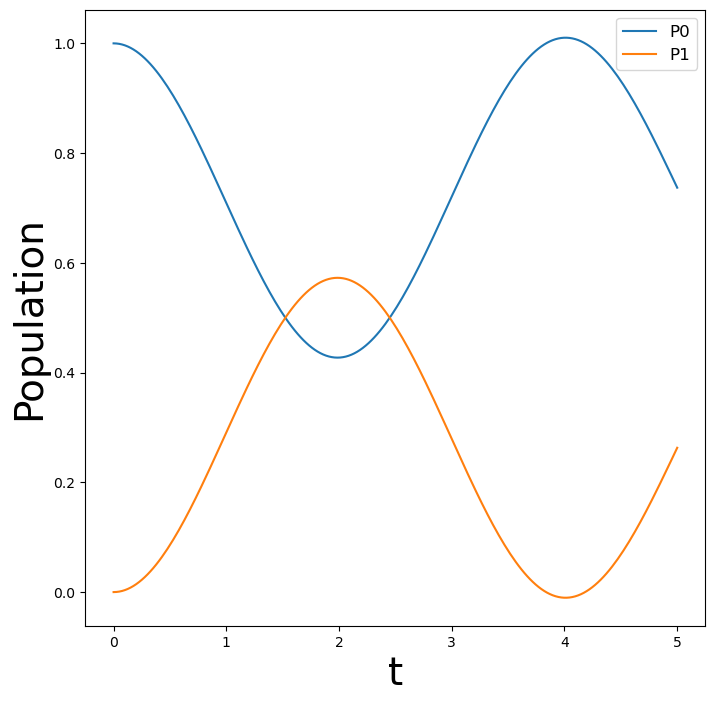

In [154]:
N_sys = 2
max_depth=2
nt = 100
tmax=30
tlist = [0, tmax, nt]
options = {"nsteps": 1500_000}
def proj(i, j):
    """ A helper function for creating an interaction operator. """
    return basis(N_sys, i) * basis(N_sys, j).dag()

# Construct one bath for each system state:
baths = []
for i in range(N_sys):
    Q = proj(i, i)
    baths.append(DrudeLorentzBath(Q, lam, gamma, T, Nk))

# Construct the system Liouvillian from the system Hamiltonian and
# bath expansion terminators:
H_sys = sum((i + 0.5) * w0* proj(i, i) for i in range(N_sys))
H_sys += sum(
  (i + j + 0.5) * g * proj(i, j)
  for i in range(N_sys) for j in range(N_sys)
  if i != j
)
HL = qutip.liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)

# Construct the solver (pass a list of baths):
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=options)

# Run the solver:
rho0 = basis(N_sys, 0) * basis(N_sys, 0).dag()
tlist = np.linspace(0, 5, 200)
e_ops = {
    f"P{i}": proj(i, i)
    for i in range(N_sys)
}
result = solver.run(rho0, tlist, e_ops=e_ops)

# Plot populations:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
for label, values in result.e_data.items():
    axes.plot(result.times, values, label=label)
axes.set_xlabel(r't', fontsize=28)
axes.set_ylabel(r"Population", fontsize=28)
axes.legend(loc=0, fontsize=12)

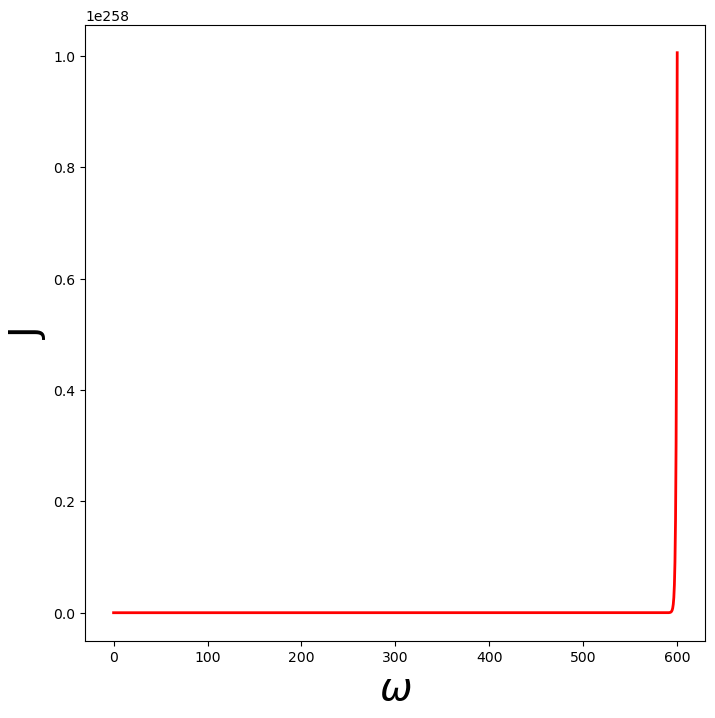

In [155]:
#lam=g**2*200
#gamma=30
#lam=g**2


def plot_spectral_density():
    """ Drude-Lorentz spectral density muss zuerst in normale spectral density umgerechnet werden """
    wk = np.linspace(0, 600, 1000)
    J = wk * 2 * lam * gamma / (gamma**2 + wk**2) *np.cosh(wk * 1)

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
    axes.plot(wk, J, 'r', linewidth=2)
    axes.set_xlabel(r'$\omega$', fontsize=28)
    axes.set_ylabel(r'J', fontsize=28)

plot_spectral_density()
plt.show()

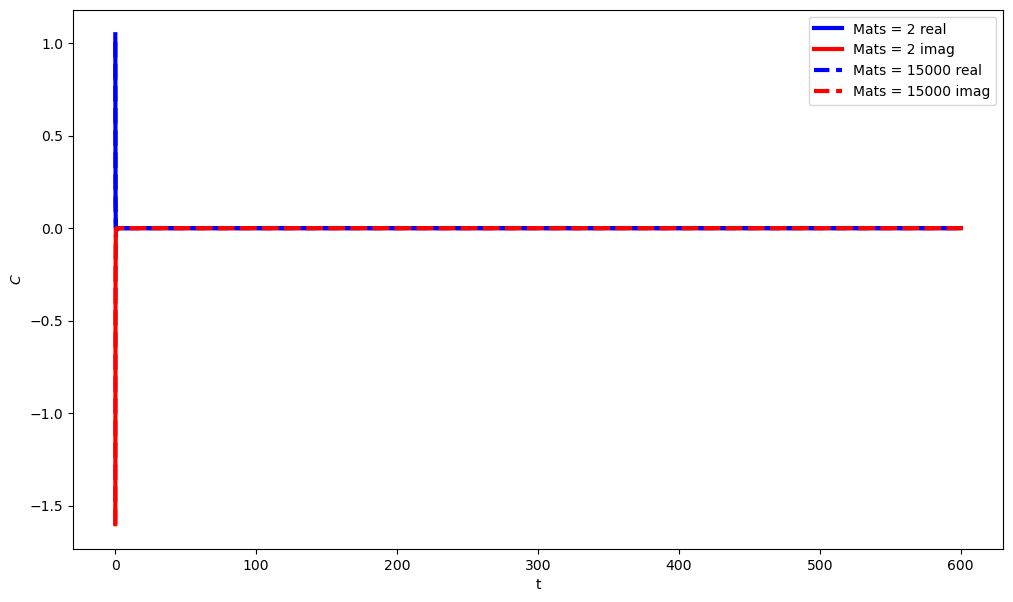

In [156]:
def dl_corr_approx(t, nk):
    """ Drude-Lorenz correlation function approximation.
    
        Approximates the correlation function at each time t to nk exponents.
    """
    tl=0.002
    c = lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t)*np.cosh( gamma*tl)
    for k in range(1, nk):
        vk = 2 * np.pi * k * T
        c += (4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(-vk * t)*np.cosh(vk*tl)
    return c


def plot_correlation_expansion_divergence(): 
    """ We plot the correlation function with a large number of Matsubara terms to show that
        the real part is slowly diverging at t = 0.
    """
    t = np.linspace(0, 600, 10000)
    # correlation coefficients with 15k and 2 terms
    corr_15k = dl_corr_approx(t, 15)
    corr_2 = dl_corr_approx(t, 10)

    fig, ax1 = plt.subplots(figsize=(12, 7))

    ax1.plot(t, np.real(corr_2), color="b", linewidth=3, label= r"Mats = 2 real")
    ax1.plot(t, np.imag(corr_2), color="r", linewidth=3, label= r"Mats = 2 imag")
    ax1.plot(t, np.real(corr_15k), "b--", linewidth=3, label= r"Mats = 15000 real")
    ax1.plot(t, np.imag(corr_15k), "r--", linewidth=3, label= r"Mats = 15000 imag")

    ax1.set_xlabel("t")
    ax1.set_ylabel(r"$C$")
    ax1.legend()
    
plot_correlation_expansion_divergence()

50.0%. Run time:   0.01s. Est. time left: 00:00:00:00
100.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.03s
10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.01s. Est. time left: 00:00:00:00
30.3%. Run time:   0.01s. Est. time left: 00:00:00:00
40.4%. Run time:   0.01s. Est. time left: 00:00:00:00
50.5%. Run time:   0.01s. Est. time left: 00:00:00:00
60.6%. Run time:   0.01s. Est. time left: 00:00:00:00
70.7%. Run time:   0.02s. Est. time left: 00:00:00:00
80.8%. Run time:   0.02s. Est. time left: 00:00:00:00
90.9%. Run time:   0.02s. Est. time left: 00:00:00:00
100.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


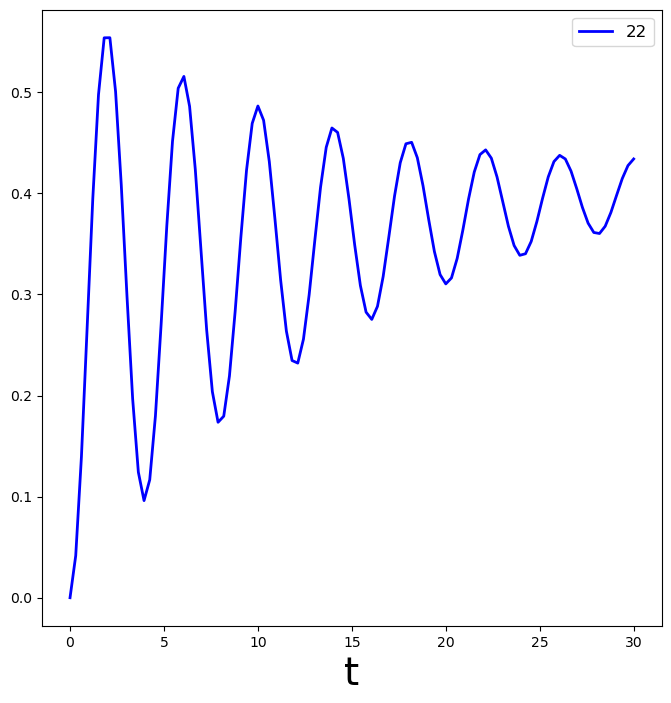

In [157]:
max_depth=2
nt = 100
tmax=30
tlist = [0, tmax, nt]
options = {"nsteps": 1500_000}
#options = Options(atol=1e-2, rtol=1e-2)
solver = HEOMSolver(H_sys, Bad1 , max_depth=max_depth, options=options)

#Gibt einen  ausdruck der zeit an. 


tlist = [0, tmax, nt]  # times to evaluate the system state at
result = solver.run(rho0, tlist)






# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()

# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):


# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()

# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):
P12p = basis(2,0) * basis(2,1).dag()
P21p = basis(2,1) * basis(2,0).dag()
# Run the solver:
tlist = np.linspace(0, tmax, nt)
result_HEOM = solver.run(rho0, tlist, e_ops={"11": P11p, "21": P21p, "12": P12p, "22": P22p})
#result_HEOM2 = solver2.run(rho0, tlist, e_ops={"11": P11p, "21": P21p, "12": P12p})
# Plot the results:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(result_HEOM.times, result_HEOM.e_data["12"], 'b', linewidth=2, label="12")
#axes.plot(result_HEOM.times, np.imag(result_HEOM.e_data["21"]), 'r', linewidth=2, label="21")
#axes.plot(result_HEOM.times, result_HEOM.e_data["11"], 'g', linewidth=2, label="11")
axes.plot(result_HEOM.times, result_HEOM.e_data["22"], 'b', linewidth=2, label="22")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)



In [158]:

H= H_sys

kappa=(g**2)/2
#psi0 = basis(2,0)

kappa_5=(nB+1)*kappa ####goes to zero
kappa_6=(nB)*kappa


def col_coeff(t, args):  # coefficient function
    return np.sqrt(kappa * np.exp(-t))

c_op_list=[]
c_op_list.append(np.sqrt(kappa_5)*a)
c_op_list.append(np.sqrt(kappa_6)*ad)

psi0 = basis(2, 0)

times = np.linspace(0.0, tmax, nt)

result = qutip.mesolve(H, rho0, tlist,c_op_list, [a])

fig, ax = plt.subplots()

ax.plot(result.times, result.expect[0])
ax.plot(result_HEOM.times, result_HEOM.e_data["a"], label="N")
#ax.plot(result_HEOM2.times, result_HEOM2.e_data["12"], 'g',label="N")
#ax.plot(result.times, result.expect[1]);

ax.set_xlabel('Time')

ax.set_ylabel('Expectation values')

ax.legend(("a-Lindbald" , "a-HEOM"))
plt.show()



NameError: name 'a' is not defined

10.1%. Run time:   0.01s. Est. time left: 00:00:00:00
20.2%. Run time:   0.02s. Est. time left: 00:00:00:00
30.3%. Run time:   0.03s. Est. time left: 00:00:00:00
40.4%. Run time:   0.04s. Est. time left: 00:00:00:00
50.5%. Run time:   0.05s. Est. time left: 00:00:00:00
60.6%. Run time:   0.05s. Est. time left: 00:00:00:00
70.7%. Run time:   0.06s. Est. time left: 00:00:00:00
80.8%. Run time:   0.07s. Est. time left: 00:00:00:00
90.9%. Run time:   0.08s. Est. time left: 00:00:00:00
100.0%. Run time:   0.09s. Est. time left: 00:00:00:00
Total run time:   0.09s
20.984117374514124


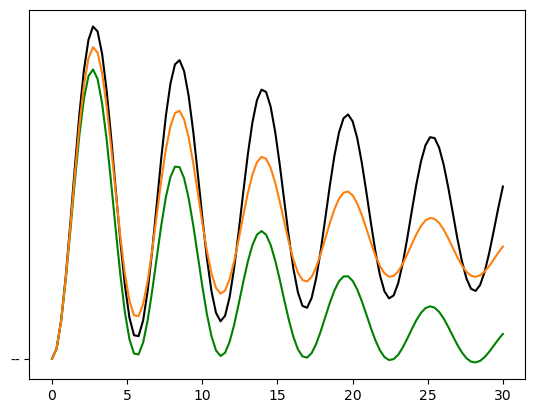

In [71]:

#max_depth=Nk

solver3 = HSolverDL(H_sys, Q, lam, T ,max_depth, 5,40 , bnd_cut_approx=False, options=options,combine=True)
result_HEOM3 = solver3.run(rho0, tlist, e_ops={"observable_a": a})
fig, ax = plt.subplots()
ax.plot(result_HEOM3.times, result_HEOM3.e_data["observable_a"],'black','--', label="N")
ax.plot(result.times, result.expect[0],'g')
ax.plot(result_HEOM.times, result_HEOM.e_data["a"], label="N")

print(gamma)

0.020000000000000004


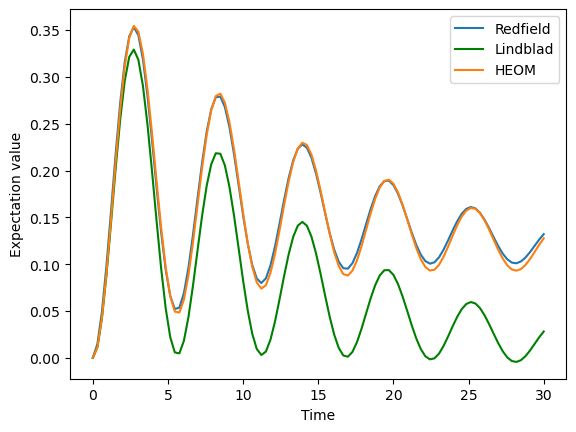

In [72]:
from Redfield import Redfield as Redfield 



def DrudeLorenz(wk): # Spektrale dichte mit Drude lorenz bad auch genannt timura terminator. 
    if wk==0:
        return 2*np.pi * lam /(np.pi *gamma*beta)
    else:
        return 2*np.pi*(2.0*lam*gamma *w /(np.pi*(w**2+gamma**2))) * ((1/(np.exp((w) * beta)-1))+1)

    
    
redfield_solver = Redfield(H=H_sys, rho0=rho0, Q=Q, a=a, ad=ad, w0=w, gamma=gamma, lam=lam, tlist=tlist,spectrum=DrudeLorenz)

    # Löse das System
rho_t_redfield = redfield_solver.Rsolver()

    # Plotte die Ergebnisse
    
fig, ax = plt.subplots()
ax.plot(rho_t_redfield.times, rho_t_redfield.expect[0],label='Redfield')
ax.plot(result.times, result.expect[0],'g',label='Lindblad') # Lindblad
ax.plot(result_HEOM.times, result_HEOM.e_data["a"], label="HEOM") #HEOM
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
print(lam)

In [73]:
import numpy as np

# Parameter für die Korrelationsfunktion
gamma = 0.1  # Dämpfungsrate
omega_c = 1.0  # Charakteristische Frequenz (z.B. Schnittfrequenz des Bades)

# Lorentzförmige Korrelationsfunktion
def lorentz_correlation(t):
    return gamma * np.exp(-omega_c * np.abs(t))

# Zeitbereich für die Korrelationsfunktion
#tlist = np.linspace(0, 10, 100)

# Berechne die Korrelationsfunktion für die Zeitliste
C_t = lorentz_correlation(times)
bad4= BosonicBath(Q, C_t, vk_real, ck_imag, vk_imag)
solver = HEOMSolver(H_sys, Bad2, max_depth=max_depth, options=options)
# Plotten der Korrelationsfunktion
import matplotlib.pyplot as plt
plt.plot(tlist, C_t, label="Lorentz-Peak Correlation")
plt.xlabel("Time")
plt.ylabel("Correlation function")
plt.legend()
plt.show()

ValueError: The bath exponent lists ck_real and vk_real, and ck_imag and vk_imag must be the same length.

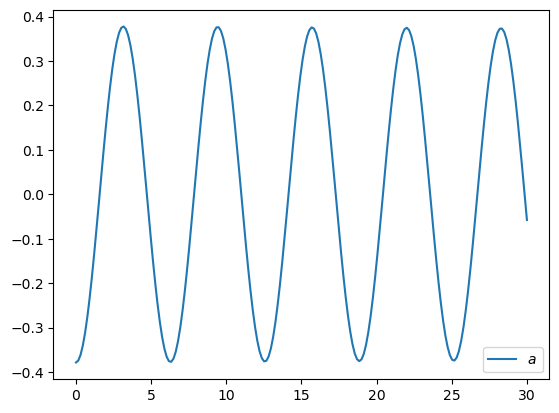

In [180]:
N = 2
w0 = 1.0 #* 2 * np.pi
#g = 0.1 * w0
#kappa = 0.15
times = np.linspace(0, 30, 200)

def DrudeLorenz(wk):
    if wk==0:
        return 2*np.pi * lam /(np.pi *gamma*beta)
    else:
        return 2*np.pi*(2.0*lam*gamma *w /(np.pi*(w**2+gamma**2))) * ((1/(np.exp((w) * beta)-1))+1)

DL = (
    f"2*pi* 2.0 * {lam} / (pi * {gamma} * {beta}) if (w == 0) else "
    f"2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {beta})-1))+1)"
)
options = Options(nsteps=15000, store_states=True,rtol=1e-12,atol=1e-12)


a = qutip.destroy(N)
H = w0 * a.dag() * a # + g * (a + a.dag())
rho0=qutip.coherent_dm(N, N)
#psi0 = qutip.ket2dm((basis(N, 4) + basis(N, 2) + basis(N, 0)).unit())
a_ops = [[g*(a+a.dag()), DrudeLorenz]]
e_ops = [ a.dag() ]

res_brme = qutip.brmesolve(H, rho0, times, a_ops,e_ops=e_ops)

plt.figure()
#plt.plot(times, res_brme.expect[0], label=r'$a^{+}a$')
plt.plot(times, res_brme.expect[0], label=r'$a$')
plt.legend()
plt.show()

    Parameters
    ----------
    H_sys : Qobj or QobjEvo or list
        The system Hamiltonian or Liouvillian. See :class:`HEOMSolver` for
        a complete description.

    coup_op : Qobj
        Operator describing the coupling between system and bath.
        See parameter ``Q`` in :class:`BosonicBath` for a complete description.

    coup_strength : float
        Coupling strength. Referred to as ``lam`` in :class:`DrudeLorentzBath`.

    temperature : float
        Bath temperature. Referred to as ``T`` in :class:`DrudeLorentzBath`.

    N_cut : int
        The maximum depth of the hierarchy. See ``max_depth`` in
        :class:`HEOMSolver` for a full description.

    N_exp : int
        Number of exponential terms used to approximate the bath correlation
        functions. The equivalent ``Nk`` in :class:`DrudeLorentzBath` is one
        less than ``N_exp`` (see note above).

    cut_freq : float
        Bath spectral density cutoff frequency. Referred to as ``gamma`` in
        :class:`DrudeLorentzBath`.

    bnd_cut_approx : bool
        Use boundary cut off approximation. If true, the Matsubara
        terminator is added to the system Liouvillian (and H_sys is
        promoted to a Liouvillian if it was a Hamiltonian). Keyword only.
        Default: False.

    options : dict, optional
        Generic solver options.
        If set to None the default options will be used. Keyword only.
        Default: None.

    combine : bool, default: True
        Whether to combine exponents with the same frequency (and coupling
        operator). See :meth:`BosonicBath.combine` for details.
        Keyword only. Default: True.
    """
    def __init__(
        self, H_sys, coup_op, coup_strength, temperature,
        N_cut, N_exp, cut_freq, *, bnd_cut_approx=False, options=None,
        combine=True,
    ):

In [181]:
Stop 

NameError: name 'Stop' is not defined

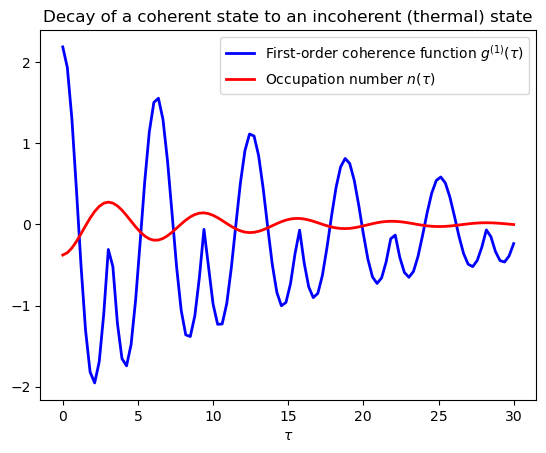

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import qutip


N = 2
taus = np.linspace(0.0,tmax,nt)
a = qutip.destroy(N)
H = w  * a.dag() * a

# collapse operator
G1 = g**2
n_th = nB  # bath temperature in terms of excitation number
c_ops = [np.sqrt(G1 * (1 + n_th)) * a, np.sqrt(G1 * n_th) * a.dag()]

# start with a coherent state
rho0 = qutip.coherent_dm(N, 2.0)

# first calculate the occupation number as a function of time
n = qutip.mesolve(H, rho0, taus, c_ops, [a]).expect[0]

# calculate the correlation function G1 and normalize with n to obtain g1
G1 = qutip.correlation_2op_1t(H, rho0, taus, c_ops, a.dag(), a)
g1 = np.array(G1) / np.sqrt(n[0] * np.array(n))

plt.plot(taus, np.real(g1), 'b', lw=2)
plt.plot(taus, n, 'r', lw=2)
plt.title('Decay of a coherent state to an incoherent (thermal) state')
plt.xlabel(r'$\tau$')
plt.legend([
    r'First-order coherence function $g^{(1)}(\tau)$',
    r'Occupation number $n(\tau)$',
])
plt.show()

[ 0.08005086+0.j          0.07960253+0.00806809j  0.07834367+0.01604586j
  0.07628776+0.02385208j  0.0734566 +0.03140738j  0.06987981+0.03863503j
  0.06559459+0.04546171j  0.06064532+0.05181826j  0.05508309+0.05764039j
  0.04896522+0.06286932j  0.04235458+0.06745237j  0.03531903+0.07134349j
  0.02793071+0.07450372j  0.02026525+0.07690161j  0.01240104+0.07851348j
  0.00441839+0.07932371j -0.0036012 +0.07932485j -0.01157601+0.07851771j
 -0.01942482+0.07691132j -0.02706777+0.07452286j -0.03442719+0.07137747j
 -0.04142839+0.06750795j -0.04800038+0.06295446j -0.05407663+0.05776408j
 -0.05959574+0.05199037j -0.06450203+0.04569273j -0.06874611+0.03893584j
 -0.07228541+0.03178906j -0.07508459+0.02432557j -0.07711588+0.01662175j
 -0.07835932+0.00875633j -0.07880307+0.00080965j -0.07844342-0.00713727j
 -0.07728482-0.01500345j -0.07533988-0.0227088j  -0.07262925-0.03017497j
 -0.0691813 -0.03732613j -0.0650319 -0.04408972j -0.06022405-0.05039725j
 -0.05480739-0.0561849j  -0.04883774-0.06139421j -0

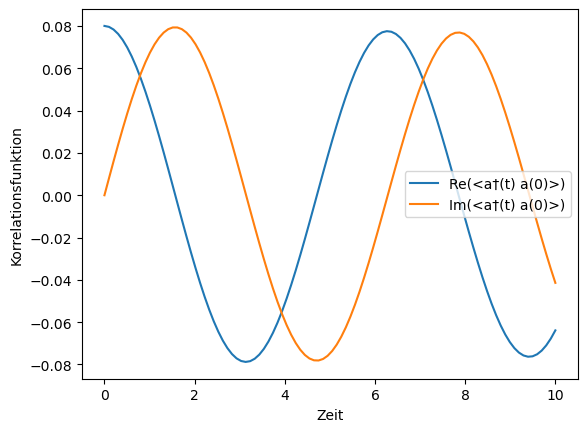

In [14]:
from qutip import correlation_2op_1t, destroy, thermal_dm

import numpy as np
import matplotlib.pyplot as plt

# Parameter für das thermische Bad
N = 2  # Anzahl der Zustände
omega = w  # Frequenz des Systems
gamma2 = g**2  # Dämpfungsrate
beta = beta  # Inverse Temperatur (beta = 1/kT)

# Erzeuge den Vernichtungsoperator für das System
a = destroy(N)

# Thermischer Zustand des Systems
rho0 = thermal_dm(N, beta * omega)

# Hamiltonian des Systems (harmonischer Oszillator)
H = omega * a.dag() * a

# Lindblad-Operator (Dissipation)
L = np.sqrt(gamma2) * a

# Zeiten für die Berechnung der Korrelationsfunktion
times = np.linspace(0, 10, 100)

# Berechnung der Korrelationsfunktion <a†(t) a(0)> mit dem Hamiltonian H und Lindblad-Operator L
correlation_values = correlation_2op_1t(H, rho0, times, [L], a.dag(), a)
print(correlation_values)
# Ausgabe und Visualisierung der Korrelationsfunktion
plt.plot(times, np.real(correlation_values), label="Re(<a†(t) a(0)>)")
plt.plot(times, np.imag(correlation_values), label="Im(<a†(t) a(0)>)")
plt.xlabel('Zeit')
plt.ylabel('Korrelationsfunktion')
plt.legend()
plt.show()
